#  目的
slt(score_length_topic)validを利用する

In [1]:
# path setting
EXP_NAME = "e038-use-slt-valid"
MODEL_NAME = "microsoft/deberta-v3-xsmall"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = True
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
# TRAINING_MAX_LENGTH= 512
TRAINING_MAX_LENGTH = 1024
INFERENCE_MAX_LENGTH = 1536
SEED = 42
EPOCH = 2  # 4
LR = 2e-05
TRAIN_BS = 8
GRAD_ACC_NUM = 16
EVAL_BS = 8
SAVE_STEP = 0.1
EVAL_STEP = 0.1
LR_SCHE_TYPE = "linear"

# TRAINED_MODEL_PATH = (
#     "/notebooks/" + "automated_essay_scoring/trained_models/e016-not-use-dropout"
# )

In [2]:
!nvidia-smi

Sat May 25 14:55:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 55%   79C    P2   295W / 300W |   4053MiB / 49140MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python --version

Python 3.11.7


In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks
Jupyter Kernel By VSCode!
/notebooks/automated_essay_scoring/data
/notebooks
Jupyter Kernel By VSCode!
/notebooks/automated_essay_scoring/trained_models/e037-use-slt-valid


In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import

In [7]:
import json
import os
import random
from typing import Optional, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import wandb
from datasets import DatasetDict, Value, concatenate_datasets, load_dataset
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    DebertaV2PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    ContextPooler,
    StableDropout,
    DebertaV2Model,
)

2024-05-25 14:56:25.186935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 14:56:25.186992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 14:56:25.188270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 14:56:25.194824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 14:56:25.977134: W tensorflow/compiler/tf2

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

wandb: Currently logged in as: sinchir0. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


'wandb'

# Data Import

In [13]:
train_dataset = load_dataset(
    "csv",
    data_files=f"{DATA_PATH}/train.csv",
    split="train",
).map(lambda example: {"flag": "original"})

train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score', 'flag'],
    num_rows: 17307
})

In [14]:
# 追加データ
persuade_dataset = (
    load_dataset(
        "csv",
        data_files={"train": f"{DATA_PATH}/persuade_w_is_tr_con_as_num.csv"},
        split="train",
    )
    .filter(lambda x: not x["is_train_contains"], num_proc=NUM_PROC)
    .select_columns(["essay_id_comp", "full_text", "holistic_essay_score"])
    .rename_columns({"essay_id_comp": "essay_id", "holistic_essay_score": "score"})
    .map(lambda example: {"flag": "persuade"})
)

persuade_dataset

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Dataset({
    features: ['essay_id', 'full_text', 'score', 'flag'],
    num_rows: 13125
})

In [15]:
# データの結合
# train_dataset = concatenate_datasets([train_dataset, persuade_dataset])

In [16]:
if DEBUG:
    train_dataset = train_dataset.shuffle(seed=SEED)
    train_dataset = train_dataset.select(range(100))
    EPOCH = 1
    SAVE_STEP = 0.5
    EVAL_STEP = 0.5

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(AddedToken("\n", normalized=False))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


1

In [18]:
def preprocess_function(examples, max_token_length: int):
    return tokenizer(
        examples["full_text"],
        max_length=max_token_length,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

Map (num_proc=8):   0%|          | 0/100 [00:00<?, ? examples/s]

In [19]:
train_dataset = train_dataset.rename_column("score", "labels")

In [20]:
set(train_dataset["labels"])

{1, 2, 3, 4, 5, 6}

In [48]:
# with open(f"{DATA_PATH}/essay_id_fold_dict.json") as f:
with open(f"{DATA_PATH}/essay_id_fold_by_slt_dict.json") as f:
    essay_id_fold_dict = json.load(f)

In [22]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'flag', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

In [23]:
# 外部データなし
def get_train_test_split_dataset(train_dataset):
    train_dataset = train_dataset.map(
        lambda x: {"fold": essay_id_fold_dict[x["essay_id"]]}, num_proc=NUM_PROC
    )

    return DatasetDict(
        {
            "train": train_dataset.filter(lambda x: x["fold"] != 2, num_proc=NUM_PROC),
            "valid": train_dataset.filter(lambda x: x["fold"] == 2, num_proc=NUM_PROC),
        }
    )


train_test_split_dataset = get_train_test_split_dataset(train_dataset)


# 外部データあり
# def get_train_test_split_dataset_w_external(train_dataset):
#     original_dataset = train_dataset.filter(
#         lambda x: x["flag"] == "original", num_proc=NUM_PROC
#     )

#     external_train_dataset = train_dataset.filter(
#         lambda x: x["flag"] != "original", num_proc=NUM_PROC
#     )

#     original_dataset = original_dataset.map(
#         lambda x: {"fold": essay_id_fold_dict[x["essay_id"]]}, num_proc=NUM_PROC
#     )

#     original_train_dataset = original_dataset.filter(
#         lambda x: x["fold"] != 2, num_proc=NUM_PROC
#     )
#     original_valid_dataset = original_dataset.filter(
#         lambda x: x["fold"] == 2, num_proc=NUM_PROC
#     )

#     train_test_split_dataset = DatasetDict(
#         {
#             "train": concatenate_datasets(
#                 [original_train_dataset, external_train_dataset]
#             ),
#             "valid": original_valid_dataset,
#         }
#     )

#     return train_test_split_dataset


# train_test_split_dataset = get_train_test_split_dataset_w_external(train_dataset)

# Check
# assert set(train_test_split_dataset["train"]["fold"]) == {0, 1}
assert set(train_test_split_dataset["valid"]["fold"]) == {2}

if not DEBUG:
    essay_id_fold_2 = {key for key, value in essay_id_fold_dict.items() if value == 2}
    assert set(train_test_split_dataset["valid"]["essay_id"]) == essay_id_fold_2
    assert len(set(train_test_split_dataset["valid"]["essay_id"])) == 5769

Map (num_proc=8):   0%|          | 0/100 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/100 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/100 [00:00<?, ? examples/s]

In [24]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [25]:
import numpy as np
import scipy as sp
from functools import partial


# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method="nelder-mead"
        )

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_["x"]


# optR = OptimizedRounder()
# optR.fit(valid_pred, valid_dataset["labels"])
# print(optR.coefficients)

# optimized = optR.predict(valid_pred, optR.coefficients)

In [26]:
# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
# def compute_metrics_for_classification(eval_pred):

#     predictions, labels = eval_pred
#     qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
#     results = {"qwk": qwk}
#     return results


# def compute_metrics_for_regression(eval_pred):
#     predictions, labels = eval_pred
#     mse = mean_squared_error(labels, predictions)
#     return {"mse": mse}


def compute_metrics_for_regression_opt(eval_pred):
    predictions, labels = eval_pred

    optR = OptimizedRounder()
    optR.fit(predictions, labels)
    optimized = optR.predict(predictions, optR.coefficients)
    print(optR.coefficients)

    qwk = cohen_kappa_score(labels, optimized, weights="quadratic")
    return {"qwk": qwk}

In [27]:
# https://dev.classmethod.jp/articles/huggingface-usage-custom-model/
# https://github.com/huggingface/transformers/blob/94b3f544a1f5e04b78d87a2ae32a7ac252e22e31/src/transformers/models/deberta_v2/modeling_deberta_v2.py#L1313
class CustomDebertaSequenceClassification(DebertaV2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        num_labels = getattr(config, "num_labels", 2)
        self.num_labels = num_labels

        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim

        self.classifier = nn.Linear(output_dim, num_labels)
        drop_out = getattr(config, "cls_dropout", None)
        drop_out = self.config.hidden_dropout_prob if drop_out is None else drop_out
        self.dropout = StableDropout(drop_out)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.deberta.get_input_embeddings()

    def set_input_embeddings(self, new_embeddings):
        self.deberta.set_input_embeddings(new_embeddings)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        # position_ids: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        # output_attentions: Optional[bool] = None,
        # output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.deberta(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            # position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            # output_attentions=output_attentions,
            # output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            logits = logits.view(-1).to(labels.dtype)
            loss = loss_fn(logits, labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [28]:
# not use dropout
# https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832
config = AutoConfig.from_pretrained(MODEL_NAME)
config.attention_probs_dropout_prob = 0.0
config.hidden_dropout_prob = 0.0
config.num_labels = 1  # REGRESSION

# regression
# https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994
# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     # num_labels=1,
#     config=config,
# )

# model = CustomModel.from_pretrained(MODEL_NAME, config=config)
# model = CustomDebertaSequenceClassification(config)
model = CustomDebertaSequenceClassification.from_pretrained(MODEL_NAME, config=config)

# model.deberta.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)

# cast labels to float for regression
train_test_split_dataset = DatasetDict(
    {
        "train": train_test_split_dataset["train"].cast_column(
            "labels", Value(dtype="float")
        ),
        "valid": train_test_split_dataset["valid"].cast_column(
            "labels", Value(dtype="float")
        ),
    }
)
print(train_test_split_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Some weights of CustomDebertaSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Casting the dataset:   0%|          | 0/62 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/38 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'labels', 'flag', 'input_ids', 'token_type_ids', 'attention_mask', 'fold'],
        num_rows: 62
    })
    valid: Dataset({
        features: ['essay_id', 'full_text', 'labels', 'flag', 'input_ids', 'token_type_ids', 'attention_mask', 'fold'],
        num_rows: 38
    })
})


In [29]:
# if not DEBUG:
#     assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
#     assert len(set(train_test_split_dataset["valid"]["labels"])) == NUM_LABELS

In [30]:
# import torch.nn as nn
# from transformers import Trainer


# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels").float()  # ラベルを float 型に変換
#         outputs = model(**inputs)
#         logits = outputs[0]

#         # MSE損失を計算
#         loss_fct = nn.MSELoss()
#         loss = loss_fct(logits.view(-1), labels.view(-1))

#         return (loss, outputs) if return_outputs else loss

In [31]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEP,
    save_strategy="steps",
    save_steps=SAVE_STEP,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    # metric_for_best_model="mse",
    warmup_ratio=0.1,
    lr_scheduler_type=LR_SCHE_TYPE,
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    greater_is_better=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics_for_regression,
    compute_metrics=compute_metrics_for_regression_opt,
)

In [32]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        num_labels=1,
        problem_type="regression",
    )

    args = TrainingArguments(
        ".",
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Qwk
1,No log,10.329037,0.000000


[1.5 2.5 3.5 4.5 5.5]


# valid_datasetの作成・保存

In [33]:
# valid_dataset = train_test_split_dataset["valid"]
# TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
valid_dataset = train_dataset.filter(
    lambda example: example["essay_id"]
    in train_test_split_dataset["valid"]["essay_id"],
    num_proc=NUM_PROC,
)

# labelsはfloatにする
valid_dataset = valid_dataset.cast_column("labels", Value(dtype="float"))

valid_dataset = valid_dataset.map(
    preprocess_function,
    batched=True,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = trainer.predict(valid_dataset).predictions.flatten()

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

Filter (num_proc=8):   0%|          | 0/100 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/38 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/38 [00:00<?, ? examples/s]

[1.5 2.5 3.5 4.5 5.5]


Map:   0%|          | 0/38 [00:00<?, ? examples/s]

In [34]:
valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/38 [00:00<?, ? examples/s]

# CVの計算

In [35]:
# for regression
def clip_valid_pred(example):
    # 四捨五入を実施
    example["valid_pred"] = np.clip(example["valid_pred"], 1, 6).round()
    return example


valid_dataset = valid_dataset.map(clip_valid_pred)

cv_score = cohen_kappa_score(
    valid_dataset["labels"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score by round: {cv_score}")

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

CV Score by round: 0.0


In [36]:
optR = OptimizedRounder()
optR.fit(valid_pred, valid_dataset["labels"])
print(optR.coefficients)

optimized = optR.predict(valid_pred, optR.coefficients)

[1.5 2.5 3.5 4.5 5.5]


In [37]:
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

In [38]:
cv_score = cohen_kappa_score(valid_dataset["labels"], optimized, weights="quadratic")

print(f"CV Score by NelderMead: {cv_score}")

CV Score by NelderMead: 0.0


In [39]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

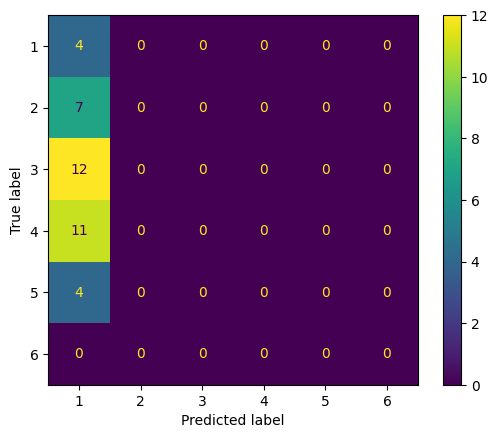

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["labels"],
    valid_dataset["valid_pred"],
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# AWSへのアップロード

In [41]:
# S3へのアップロード
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{output_name}"
    )

In [42]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

# Kaggle Datasetへのupload

In [43]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

# ローカルからのデータの削除

In [44]:
if not DEBUG and (UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE):
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [45]:
if WANDB:
    wandb.finish()

eval/loss,▁
eval/qwk,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/loss,10.32904
eval/qwk,0.0
eval/runtime,1.0709
eval/samples_per_second,35.483


In [46]:
print("finish Notebook!")

finish Notebook!
